# Regression and Classification with the Ames Housing Data

---

## Premise: 
I have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

## Data:
The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt

## Objective:
1. Develop an algorithm to estimate the value of the residential homes based on fixed characteristics (those that are not considered easy to renovate).
2. Identify characteristics of homes that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Use the information to buy homes that are likely to sell for more than the initial purchase.

## Process:
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize and evaluate the model. (How does it perform and what are the best estimates of price?)

In [11]:
!pip install display --quiet

In [13]:
import sys
import numpy as np, pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt, seaborn as sns

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Load and Inspect the Data

In [3]:
df_house = pd.read_csv('../assets/housing.csv')

**The size of my dataset is 4.1 MB as shown below:**

In [15]:
sys.getsizeof(df_house)/1000000

4.091622

**Get an overview of the data**
- view the pandas DataFrame
- examine the shape
- check for null values
- assess what kind of cleaning / EDA needs to be completed

In [4]:
df_house.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1301,1302,70,RL,NaN,7500,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,11,2009,WD,Normal,177500
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
1384,1385,50,RL,60.0,9060,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,10,2009,WD,Normal,105000
160,161,20,RL,NaN,11120,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,162500
809,810,75,RM,90.0,8100,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,11,2009,WD,Normal,106000


In [5]:
df_house.shape

(1460, 81)

**Observations from `.info()` (below)**
- There are several categories that have *null values* that may need to be addressed. For cases where there are null values, some *statistical* analysis must be completed to assess how to fill the null values. Consider dropping rows where appropriate.
- There are various *data types* that might require conversion or a different way of handling for purposes of building a predictive model.
- There appear to be categories are very similar to one another, therefore it might suffice that one of the features in a group of features might be enough to predict sales price. For Eample, there are 7 different Garage features, where one or two of the Garage features might be sufficient to help predict sales price. *Colinearity* or *multilinearity* needs to be examined to eliminate any redundant features.

In [6]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

**Drop non-residential data from the DataFrame**
Based on the data dictionary, there is non-residential data in the dataset, which is not relevant to the necessary analysis to meet the objectives. Therefore, the non-residential data can be dropped from the DataFrame. The non-residential data is denoted by the following codes in the 'MSZoning' column:
- A: Agriculture
- C: Commercial
- FV: Floating Village Residential
- I: Industrial

In [17]:
df_house['MSZoning'].unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [22]:
df_house = df_house[(df_house['MSZoning'] != 'C (all)') & (df_house['MSZoning'] != 'FV')]
df_house['MSZoning'].unique() # to check that the non-residential properties have been dropped from the dataset

array(['RL', 'RM', 'RH'], dtype=object)

In [26]:
display(df_house.shape) # the new shape after the non-residential data was removed
display(1460-1385) # the number of rows dropped when non-residential data was removed

(1385, 81)

75

**Updated Size of Dataset is now 3.89MB**

In [23]:
sys.getsizeof(df_house)/1000000

3.892008

### Perform any cleaning, feature engineering, and EDA.

List the columns in the DataFrame and decide which features are considered easily renovatable vs. those that are not. This decision making was based on examining the data dictionary and some external research on renovation costs.
     - http://cdnassets.hw.net/b6/3d/047accdd4174a4965051631d7900/cvv-2010-2011-professional-desmoinesia.pdf
 
Notably, Ames data was not available on the website. However, there was data for a neighboring county (Des Moines, IA). Assuming the renovation job cost, and value recouped do not vary too much from Des Moines, IA to Ames, IA, this pdf should serve to better inform me as to which features are considered easily renovatable vs. not easily renovatable.

In [31]:
display(df_house['SalePrice'].describe())
display(stats.mode(df_house['SalePrice']))

count      1385.000000
mean     180136.283032
std       79906.363281
min       37900.000000
25%      129000.000000
50%      160000.000000
75%      212900.000000
max      755000.000000
Name: SalePrice, dtype: float64

ModeResult(mode=array([140000]), count=array([20]))

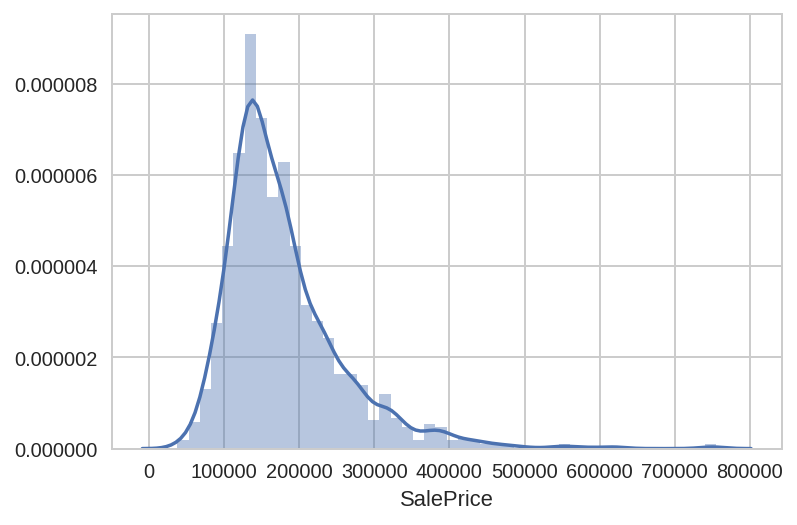

In [30]:
_ = sns.distplot(df_house['SalePrice'])

Based on the distribution plot above, it appears that the Sales Price is skewed to the left, but is normally distributed for the most part. Therefore, I will look at the mean Sale Price of $180,136.28 and set a threshold for what I consider to be a major renovation vs. a minor renovation. If a renovation costs greater than 25 percent of the average Sale Price, then it is considered a major renovation. 

$$0.25 * $180,136.28 = $45,034.07$$.

Pairing this information with the job cost vs. cost recouped report for Des Moines, IA the following feature-types are deemed major renovations (fixed features):
1. Attic 
2. Basement 
3. Living Room 
4. Kitchen
5. Sunroom / Deck / Porch
6. Number of Stories
7. Bathroom
8. Garage

All other features will be deemed easy-to-renovate with the exception of a handfull more. 

In [36]:
df_house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [40]:
easytofix = ['Utilities', 'RoofStyle', 'RoofMat1', 'MasVnrType', 'MasVnrArea', 'Heating', 'HeatingQC', 'CentralAir',\
            'Electrical', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'Fireplaces', \
             'FireplaceQu', 'Fence']

hardtofix = ['BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'Exterior1st', 'Exterior2nd', 'ExterQual', \
            'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',\
             'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', \
            'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd','Functional', 'GarageType', 'GarageYrBlt', \
             'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual','GarageCond', 'PavedDrive', 'WoodDeckSF',\
             'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC']

unabletofix = ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour',\
              'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'YearBuilt', 'YearRemodAdd', \
               'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType','SaleCondition']

In [41]:
display(len(easytofix))
display(len(hardtofix))
display(len(unabletofix))

17

41

22

**Now examine any collinearity between similarly grouped features.** In some cases there are null values, and without filling in the null values, we'll have an incomplete picture of collinearity that might exist since correlation coefficients cannot be generated with columns that hold null values.

In [57]:
basement_features = df_house[['BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1','BsmtFinType2', \
                              'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']]
display(basement_features.info())
display(basement_features.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1385 entries, 0 to 1459
Data columns (total 9 columns):
BsmtQual        1348 non-null object
BsmtCond        1348 non-null object
BsmtExposure    1347 non-null object
BsmtFinType1    1348 non-null object
BsmtFinSF1      1385 non-null int64
BsmtFinType2    1347 non-null object
BsmtFinSF2      1385 non-null int64
BsmtUnfSF       1385 non-null int64
TotalBsmtSF     1385 non-null int64
dtypes: int64(4), object(5)
memory usage: 108.2+ KB


None

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
count,1385.000000,1385.000000,1385.000000,1385.000000
mean,450.666426,49.070036,562.882310,1062.618773
std,459.231291,165.258530,443.129021,443.785047
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,216.000000,800.000000
50%,387.000000,0.000000,470.000000,994.000000
75%,719.000000,0.000000,803.000000,1306.000000
max,5644.000000,1474.000000,2336.000000,6110.000000


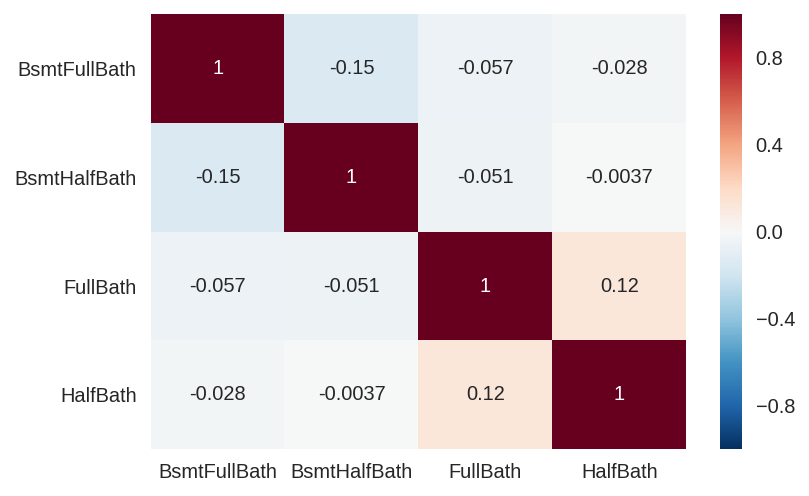

In [52]:
bathroom_features = df_house[['BsmtFullBath', 'BsmtHalfBath', 'FullBath','HalfBath']]
_ = sns.heatmap(bathroom_features.corr(), annot=True)

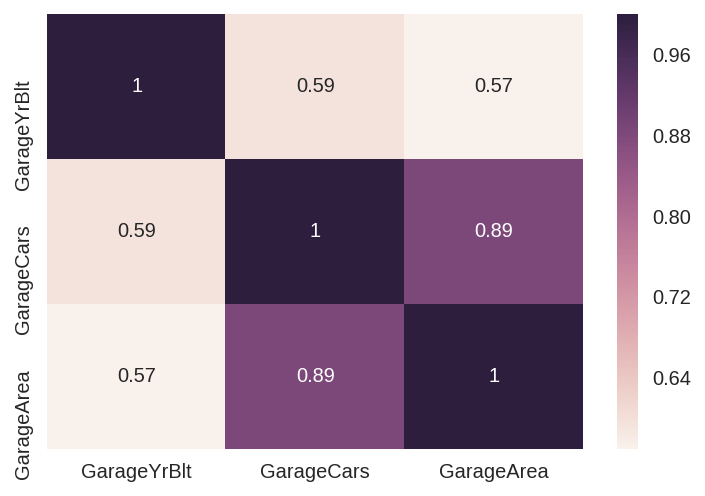

In [55]:
garage_features = df_house[['GarageType','GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', \
                            'GarageQual','GarageCond',]]
_ = sns.heatmap(garage_features.corr(), annot=True)

In [15]:
column_quality = ['OverallQual', 'ExterQual', 'BsmtQual', 'BsmtFinType1', 'BsmtFinType2', 'KitchenQual', 
                  'FireplaceQu', 'GarageQual', 'Fence', 'PoolQC']
column_condition = ['OverallCond', 'ExterCond', 'BsmtCond', 'GarageCond']
column_heat_elec = ['Heating', 'HeatingQC', 'CentralAir', 'Electrical']

In [16]:
#list comprehension for all other columns
column_all_others = [col for col in df_house.columns if (col not in (column_quality + 
                                                                     column_condition + 
                                                                     column_heat_elec)) ]

# check that the lenght of columns_all_others = 81 - 10 (quality) - 4 (condition) - 4 (heat/electric)
len(column_all_others)

63

In [17]:
# B.2 clean up null values in the df_house dataframe by inspecting subsetted dataframes
df_quality = df_house[column_quality]
df_quality.isnull().sum()

OverallQual        0
ExterQual          0
BsmtQual          37
BsmtFinType1      37
BsmtFinType2      38
KitchenQual        0
FireplaceQu      641
GarageQual        79
Fence           1108
PoolQC          1378
dtype: int64

In [18]:
# B.2.a Look at the basebement metric. Where there is total basement SF of 0, there should be NA in condition
# and quality metrics. Convert the NaNs into 'NA' and then subsequently use the label encoder for certain
# quality and or condition metrics for the basement to clean and ulitmately run through feature selection process

df_house[df_house['TotalBsmtSF'] == 0][['TotalBsmtSF', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                                        'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF']].sample(5)

,TotalBsmtSF,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF
533,0,NaN,NaN,NaN,NaN,0,NaN,0,0
1218,0,NaN,NaN,NaN,NaN,0,NaN,0,0
553,0,NaN,NaN,NaN,NaN,0,NaN,0,0
1216,0,NaN,NaN,NaN,NaN,0,NaN,0,0
1045,0,NaN,NaN,NaN,NaN,0,NaN,0,0


In [19]:
df_house['BsmtQual'].replace(np.nan, 'NA', inplace=True)
df_house['BsmtCond'].replace(np.nan, 'NA', inplace=True)
df_house['BsmtExposure'].replace(np.nan, 'NA', inplace=True)
df_house['BsmtFinType1'].replace(np.nan, 'NA', inplace=True)
df_house['BsmtFinType2'].replace(np.nan, 'NA', inplace=True)

In [20]:
df_house[['TotalBsmtSF', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 
          'BsmtFinSF2', 'BsmtUnfSF']].isnull().sum()

TotalBsmtSF     0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinSF1      0
BsmtFinType2    0
BsmtFinSF2      0
BsmtUnfSF       0
dtype: int64

In [21]:
# B.2.b. Look at the fireplace metrics. 
df_house['FireplaceQu'].replace(np.nan, 'NA', inplace=True)

In [22]:
df_house[['Fireplaces', 'FireplaceQu']].isnull().sum()

Fireplaces     0
FireplaceQu    0
dtype: int64

In [23]:
# B.2.c. Cleanup Garage metrics
df_house[df_house['GarageArea']==0][['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 
                                     'GarageQual', 'GarageCond']].sample(5)

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
127,NaN,NaN,NaN,0,0,NaN,NaN
1337,NaN,NaN,NaN,0,0,NaN,NaN
1143,NaN,NaN,NaN,0,0,NaN,NaN
241,NaN,NaN,NaN,0,0,NaN,NaN
125,NaN,NaN,NaN,0,0,NaN,NaN


In [24]:
df_house['GarageType'].replace(np.nan, 'NA', inplace=True)
df_house['GarageYrBlt'].replace(np.nan, 'NA', inplace=True)
df_house['GarageFinish'].replace(np.nan, 'NA', inplace=True)
df_house['GarageQual'].replace(np.nan, 'NA', inplace=True)
df_house['GarageCond'].replace(np.nan, 'NA', inplace=True)

In [25]:
# B.2.d. Cleanup Fence metrics
df_house['Fence'].replace(np.nan, 'NA', inplace=True)

In [26]:
# B.2.e. Cleanup Pool metrics
# if Pool Area = 0, then check to see if there is nan in all cases for PoolQC
df_house[df_house['PoolArea'] == 0][['PoolArea', 'PoolQC']]
df_house['PoolQC'].replace(np.nan, 'NA', inplace=True)

In [27]:
df_condition = df_house[column_condition]
df_condition.isnull().sum()

OverallCond    0
ExterCond      0
BsmtCond       0
GarageCond     0
dtype: int64

In [28]:
df_heat_elec = df_house[column_heat_elec]
df_heat_elec.isnull().sum()

Heating       0
HeatingQC     0
CentralAir    0
Electrical    1
dtype: int64

In [29]:
# B.2.f Clean up the null value out of Electrical
pd.isnull(df_house[['Electrical']]).any()

Electrical    True
dtype: bool

In [30]:
np.where(df_house['Electrical'].isnull())

(array([1306]),)

In [31]:
df_house['Electrical'].value_counts()

SBrkr    1263
FuseA      90
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [32]:
df_house.iloc[[1306]]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,1380,80,RL,73.0,9735,Pave,NaN,Reg,Lvl,AllPub,...,0,NA,NA,NaN,0,5,2008,WD,Normal,167500


In [33]:
#replace the null value with the S8rkr value since it is the mos requently occurring 
df_house['Electrical'].replace(np.nan, 'SBrkr', inplace=True)

In [34]:
df_all_others = df_house[column_all_others]
df_all_others.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1385 entries, 0 to 1459
Data columns (total 63 columns):
Id               1385 non-null int64
MSSubClass       1385 non-null int64
MSZoning         1385 non-null object
LotFrontage      1134 non-null float64
LotArea          1385 non-null int64
Street           1385 non-null object
Alley            65 non-null object
LotShape         1385 non-null object
LandContour      1385 non-null object
Utilities        1385 non-null object
LotConfig        1385 non-null object
LandSlope        1385 non-null object
Neighborhood     1385 non-null object
Condition1       1385 non-null object
Condition2       1385 non-null object
BldgType         1385 non-null object
HouseStyle       1385 non-null object
YearBuilt        1385 non-null int64
YearRemodAdd     1385 non-null int64
RoofStyle        1385 non-null object
RoofMatl         1385 non-null object
Exterior1st      1385 non-null object
Exterior2nd      1385 non-null object
MasVnrType       1380 non

In [35]:
# B.2.g I assumed that the null values in the Alley column are intended to mean that there is no alley access
# for that given property, therefore I opted to fill the nan with 'NA'

df_house['Alley'].replace(np.nan, 'NA', inplace=True)

In [36]:
# B.2.h Rinse & Repeat B.2.g for MasVnrType and MasVnrArea and MiscFeature

df_house['MasVnrType'].replace(np.nan, 'NA', inplace=True)
df_house['MasVnrArea'].replace(np.nan, 'NA', inplace=True)
df_house['MiscFeature'].replace(np.nan, 'NA', inplace=True)

In [37]:
df_house['MasVnrArea'] = df_house['MasVnrArea'].convert_objects(convert_numeric=True)

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [38]:
df_house['MasVnrArea'].fillna(np.nanmean(df_house['MasVnrArea']), inplace=True)

In [39]:
np.where(df_house['MasVnrArea'].isnull())

(array([], dtype=int64),)

In [40]:
# B.2.i Inspect the LotFrontage column because there are ~150 null values
df_house['LotFrontage'].describe()

count    1134.000000
mean       70.583774
std        24.251032
min        21.000000
25%        60.000000
50%        70.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [41]:
import scipy.stats as stats
# figure out what to impute the nan values with for my column 'LotFrontage'

In [42]:
# imported stats in order to see what the mode is and how frequently the mode value occurs
# it occurs 137/1134 non-null instances, which is approximately 12% of the data.

stats.mode(df_house['LotFrontage'])

ModeResult(mode=array([ 60.]), count=array([137]))

In [43]:
# examine the non-null values

temp_LotFrontage = df_house['LotFrontage'].dropna()

In [44]:
temp_LotFrontage.shape

(1134,)

In [45]:
type(temp_LotFrontage)

pandas.core.series.Series

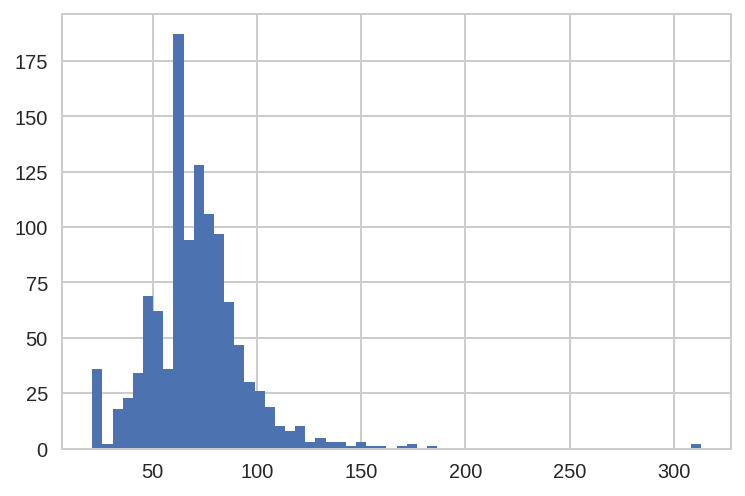

In [46]:
plt.hist(temp_LotFrontage, bins=60)
plt.show()
# Look at how skewed this data is!
# Fill in the Nan values with the mode instead of the mean
# Did not assume that if there was no Lot Frontage that Lot Frontage was zero.
# It could just be missing information.

In [47]:
df_house['LotFrontage'].replace(np.nan, 60, inplace=True)

In [48]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1385 entries, 0 to 1459
Data columns (total 81 columns):
Id               1385 non-null int64
MSSubClass       1385 non-null int64
MSZoning         1385 non-null object
LotFrontage      1385 non-null float64
LotArea          1385 non-null int64
Street           1385 non-null object
Alley            1385 non-null object
LotShape         1385 non-null object
LandContour      1385 non-null object
Utilities        1385 non-null object
LotConfig        1385 non-null object
LandSlope        1385 non-null object
Neighborhood     1385 non-null object
Condition1       1385 non-null object
Condition2       1385 non-null object
BldgType         1385 non-null object
HouseStyle       1385 non-null object
OverallQual      1385 non-null int64
OverallCond      1385 non-null int64
YearBuilt        1385 non-null int64
YearRemodAdd     1385 non-null int64
RoofStyle        1385 non-null object
RoofMatl         1385 non-null object
Exterior1st      1385 non

## Identify fixed features that can predict price.

In [49]:
list_fixed_features_cat = [
    'MSSubClass',
    'MSZoning',
    'Street',
    'Alley',
    'LotShape',
    'LandContour',
    'Utilities',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'YearBuilt',
    'Foundation',
    'BsmtFullBath',
    'BsmtHalfBath',
    'FullBath',
    'HalfBath',
    'BedroomAbvGr',
    'KitchenAbvGr',
    'TotRmsAbvGrd',
    'Functional',
    'Fireplaces',
    'GarageType',
    'GarageYrBlt',
    'GarageFinish',
    'GarageCars',
    'PavedDrive',
    'MiscFeature',
    'MoSold',
    'YrSold',
    'SaleType',
    'SaleCondition'
]

In [50]:
list_fixed_features_num = [
    'LotFrontage',
    'LotArea',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'TotalBsmtSF',
    'BsmtUnfSF',
    '1stFlrSF',
    '2ndFlrSF',
    'GrLivArea',
    'WoodDeckSF',
    'OpenPorchSF',
    'EnclosedPorch',
    '3SsnPorch',
    'ScreenPorch',    
    'PoolArea',
    'MiscVal',
    'GarageArea'
]

In [51]:
list_unfixed_features = [col for col in df_house if col not in list_fixed_features_cat + list_fixed_features_num]
list_unfixed_features

['Id',
 'OverallQual',
 'OverallCond',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'LowQualFinSF',
 'KitchenQual',
 'FireplaceQu',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'SalePrice']

In [52]:
df_fixed_features = df_house[list_fixed_features_cat + list_fixed_features_num]
df_fixed_features.sample(5)

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,2ndFlrSF,GrLivArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,GarageArea
1102,20,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0,1134,0,16,0,0,0,0,0,254
215,20,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,NAmes,...,0,1236,0,0,0,0,0,0,0,447
1069,45,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0,893,0,0,0,0,0,0,0,576
1446,20,RL,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,...,0,1188,261,39,0,0,0,0,0,312
445,20,RL,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,Edwards,...,0,1689,0,0,0,0,0,0,0,480


In [53]:
df_fixed_features.shape

(1385, 53)

In [54]:
df_fixed_features_dummies = pd.get_dummies(df_fixed_features, dummy_na = True, columns=list_fixed_features_cat)
df_fixed_features_dummies.shape

(1385, 469)

In [55]:
df_fixed_features_dummies.columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'TotalBsmtSF', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       ...
       'SaleType_Oth', 'SaleType_WD', 'SaleType_nan', 'SaleCondition_Abnorml',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial', 'SaleCondition_nan'],
      dtype='object', length=469)

## Train a model on pre-2010 data and evaluate its performance on the 2010 houses.

In [56]:
# split the data by YrSold for pre-2010 vs. 2010
# the train-test-split seems very specific

In [57]:
df_fixed_features['YrSold'].unique()

array([2008, 2007, 2006, 2009, 2010])

In [58]:
df_fixed_features['YrSold'].value_counts()

2009    321
2007    313
2006    299
2008    288
2010    164
Name: YrSold, dtype: int64

In [59]:
# predict on SalePrice (which is no longer part of the df_fixed_features_dummies or df_fixed_features dataframe)
# do a manual train/test/split

# X_train will be all the feature columns and rows for which sales occured in years prior to 2010
# X_test will be all the feature columns and rows for which sales occured in 2010
# y_train will be all the sales prices for which the sale occured prior to 2010
# y_test will be all the sales prices for which the sale occured in 2010

In [60]:
y_train = df_house[df_house['YrSold'] != 2010]['SalePrice']
y_test = df_house[df_house['YrSold'] == 2010]['SalePrice']

In [61]:
y_train.shape

(1221,)

In [62]:
y_test.shape

(164,)

In [63]:
X_test = df_fixed_features_dummies[df_fixed_features_dummies['YrSold_2010.0'] != 0]
X_train = df_fixed_features_dummies[df_fixed_features_dummies['YrSold_2010.0'] == 0]

In [64]:
X_test.shape

(164, 469)

In [65]:
X_train.shape

(1221, 469)

In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

# This ia feature dense data frame made more dense by getting dummies on several categorical featurs.


In [67]:
from sklearn.feature_selection import f_regression

In [115]:
rfr_pipe = Pipeline([
    ('skb', SelectKBest(score_func=f_regression)),
    ('scaler', StandardScaler()),
    ('sfm', SelectFromModel(Lasso())),
    ('regr', RandomForestRegressor(verbose=1, n_jobs=-1))
     ])

In [117]:
params = {
    'skb__k': [75, 100, 125],
    'sfm__estimator':[Lasso(alpha=a) for a in np.logspace(1, 3, 7)],
    'regr__n_estimators': [75, 100, 125],
    'regr__max_depth': [100, 200, None],
}
    

In [118]:
gs_rfr = GridSearchCV(rfr_pipe,
                      param_grid=params,
                      n_jobs=-1,
                      cv=ShuffleSplit(n_splits=5, random_state=42), verbose=1)

In [119]:
gs_rfr.fit(X_train, y_train)

Fitting 5 folds for each of 189 candidates, totalling 945 fits


/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  retur

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWar

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/s

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 ou

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (sel

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/opt/conda/lib/python3.5/site-packages/sklearn/featur

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning:

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Pa

[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/p

[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: inva

[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/s

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-pack

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr 

[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: Runtime

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
/opt/conda/lib/python3.5/site-pack

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < 

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= 

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < se

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_

[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elaps

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (sel

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/opt/conda/lib/python3.5/site-packages/sklearn/featur

[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.4s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/s

[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.1s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (sel

[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/opt/conda/lib/python3.5/site-packages/sklea

[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & 

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 ou

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (sel

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/st

[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in 

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 ou

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (sel

[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: 

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/s

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 ou

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < 

[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.8s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      |

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < se

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Pa

/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elaps

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond

[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastruc

[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-pack

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s


/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 =

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/con

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in les

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 ou

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/p

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_d

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < se

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/op

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.1s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: Runtime

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.1s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < 

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.1s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: Ru

[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < 

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: Ru

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.1s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/p

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.1s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: Ru

[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_d

[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < 

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr 

[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/s

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 ou

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapse

[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value enc

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/featur

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.6s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeW

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  75 out

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in les

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/s

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 ou

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/p

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encount

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/s

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 ou

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:

/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  ret

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWar

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-pack

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.4s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s


/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 =

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/li

/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.4s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning:

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.4s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[

/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elaps

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.1s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jo

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.1s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/li

[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
/opt/conda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/opt/conda/lib/python3.5/site-pack

/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.0s finished
[Pa

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=Pipeline(steps=[('skb', SelectKBest(k=100, score_func=<function f_regression at 0x7efdc29977b8>)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sfm', SelectFromModel(estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, preco...imators=10, n_jobs=-1, oob_score=False, random_state=None,
           verbose=1, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'regr__max_depth': [100, 200, None], 'regr__n_estimators': [75, 100, 125], 'skb__k': [75, 100, 125], 'sfm__estimator': [Lasso(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0....e=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=Fals

In [120]:
pd.DataFrame(gs_rfr.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_regr__max_depth,param_regr__n_estimators,param_sfm__estimator,param_skb__k,params,rank_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
144,0.703196,0.104801,0.839495,0.972015,None,75,"Lasso(alpha=1000.0, copy_X=True, fit_intercept...",75,"{'regr__max_depth': None, 'regr__n_estimators'...",1,...,0.774719,0.976913,0.888928,0.972448,0.865592,0.971213,0.036011,0.003208,0.047930,0.002732
166,1.043906,0.104145,0.835948,0.973650,None,100,"Lasso(alpha=1000.0, copy_X=True, fit_intercept...",100,"{'regr__max_depth': None, 'regr__n_estimators'...",2,...,0.763336,0.975865,0.894864,0.973353,0.837581,0.974332,0.039275,0.003429,0.049050,0.001525
60,1.140407,0.103475,0.834159,0.973044,100,125,"Lasso(alpha=1000.0, copy_X=True, fit_intercept...",75,"{'regr__max_depth': 100, 'regr__n_estimators':...",3,...,0.769707,0.973771,0.892053,0.972715,0.851281,0.973175,0.048977,0.002147,0.048274,0.001925
61,1.265262,0.104828,0.833118,0.973134,100,125,"Lasso(alpha=1000.0, copy_X=True, fit_intercept...",100,"{'regr__max_depth': 100, 'regr__n_estimators':...",4,...,0.759035,0.972681,0.882472,0.974901,0.853248,0.972604,0.068758,0.002522,0.048942,0.000904
165,0.875984,0.105538,0.832748,0.973300,None,100,"Lasso(alpha=1000.0, copy_X=True, fit_intercept...",75,"{'regr__max_depth': None, 'regr__n_estimators'...",5,...,0.765101,0.976216,0.896620,0.972005,0.839958,0.972551,0.041576,0.003550,0.049807,0.001984


In [121]:
gs_rfr.best_score_

0.83949466362017167

In [122]:
gs_rfr.score(X_train, y_train)

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished


0.97330808500012456

In [156]:
gs_rfr.score(X_test, y_test)

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished


0.84994204048853716

In [124]:
gs_rfr.best_params_
# GridSearch recommended the largest alpha of 1000 

{'regr__max_depth': None,
 'regr__n_estimators': 75,
 'sfm__estimator': Lasso(alpha=1000.0, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False),
 'skb__k': 75}

In [125]:
skb_mask = gs_rfr.best_estimator_.named_steps['skb'].get_support()

In [126]:
skb_mask.sum()
# GridSearch recommended SelectKBest k features to be 75

75

In [127]:
sfm_mask = gs_rfr.best_estimator_.named_steps['sfm'].get_support()

In [128]:
sfm_mask.sum() 
# Lasso further reduced the number of features from 75 (as a result of SelectKBest) to 47.

47

In [143]:
feat_cols = X_train.columns[skb_mask]

In [144]:
feat_imps = gs_rfr.best_estimator_.named_steps['regr'].feature_importances_

In [145]:
cols_and_imps = list(zip(feat_cols, feat_imps))
cols_and_imps

[('LotFrontage', 0.021280741521650871),
 ('LotArea', 0.023428725010210965),
 ('MasVnrArea', 0.04854020239788906),
 ('BsmtFinSF1', 0.073111750810419984),
 ('TotalBsmtSF', 0.038541294118572225),
 ('BsmtUnfSF', 0.25623858786348003),
 ('1stFlrSF', 0.010967783452466446),
 ('2ndFlrSF', 0.016430383517130151),
 ('GrLivArea', 0.031497768135781416),
 ('WoodDeckSF', 0.0015399924713515847),
 ('OpenPorchSF', 0.0043710374156948418),
 ('GarageArea', 0.0024827231067517134),
 ('MSSubClass_30.0', 0.0020027175195343064),
 ('MSSubClass_50.0', 0.0013589322727610136),
 ('MSSubClass_60.0', 0.004431630632493507),
 ('MSZoning_RL', 0.0011335103904801243),
 ('MSZoning_RM', 0.0014527533077646063),
 ('LotShape_IR1', 0.0010445613676515937),
 ('LotShape_Reg', 0.00085869394881290455),
 ('Neighborhood_BrkSide', 0.00057568711032683888),
 ('Neighborhood_Edwards', 0.0024306099321387263),
 ('Neighborhood_NAmes', 0.0023501908432527639),
 ('Neighborhood_NoRidge', 0.0126450238273213),
 ('Neighborhood_NridgHt', 0.001972893690

In [146]:
cols_and_imps.sort(key=lambda x:x[1], reverse=True)

In [147]:
df_fixed_feat_imp = pd.DataFrame(cols_and_imps)
df_fixed_feat_imp.rename(columns={1:'importance',0:'column'}, inplace=True)
df_fixed_feat_imp.head()

,column,importance
0,BedroomAbvGr_4.0,0.381805
1,BsmtUnfSF,0.256239
2,BsmtFinSF1,0.073112
3,MasVnrArea,0.048540
4,TotalBsmtSF,0.038541


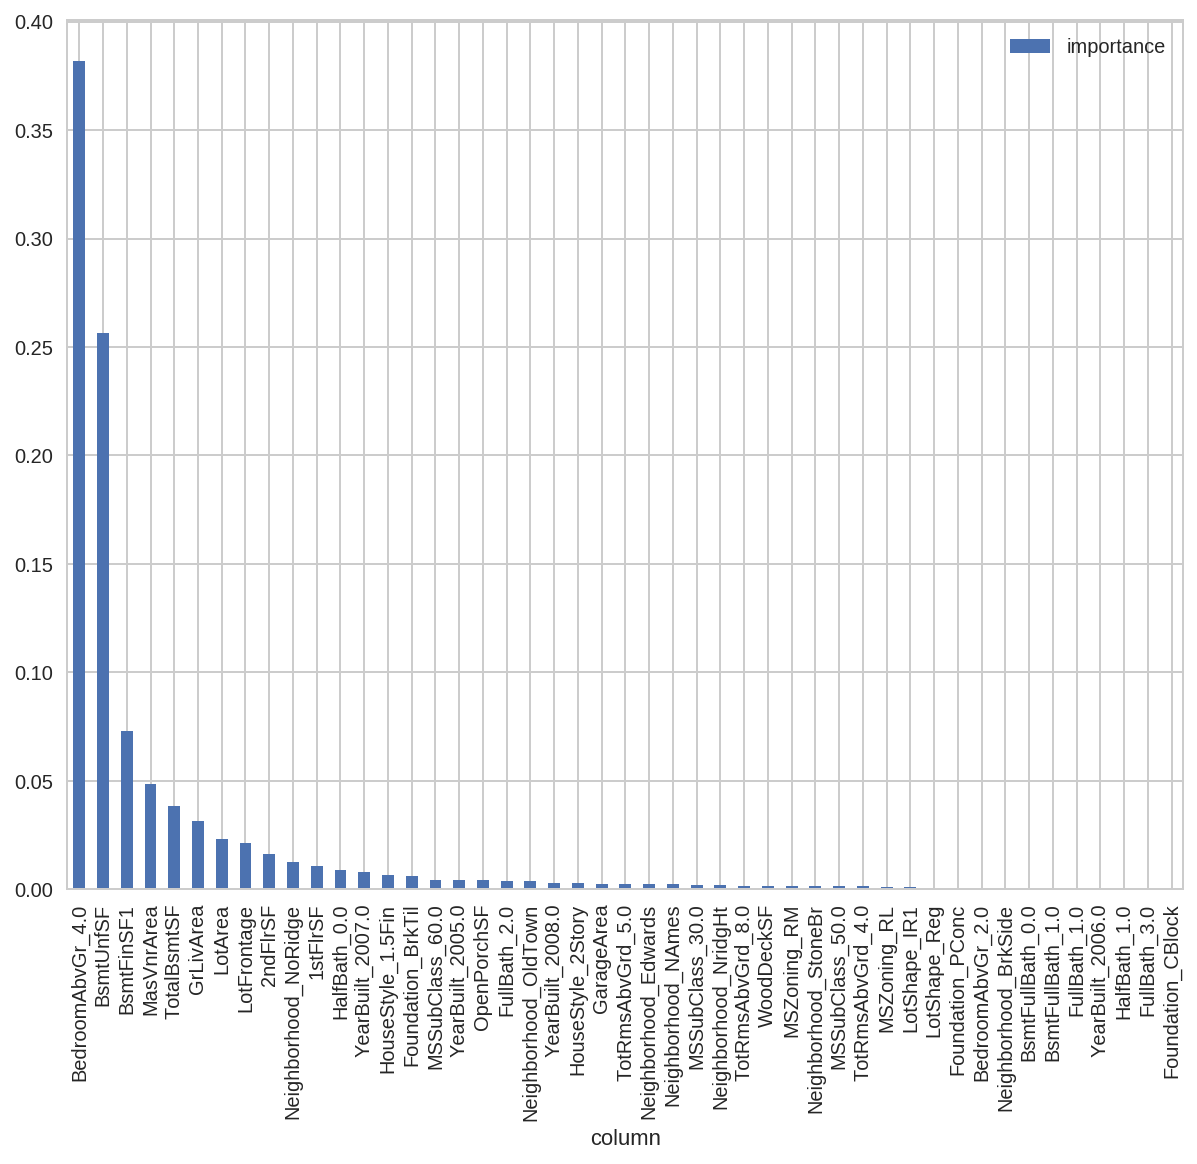

In [148]:
df_fixed_feat_imp.plot.bar('column','importance', figsize=(10,8))
plt.show()

In [152]:
# I'm concerned only with features that have importance > 0.005
# create a mask for the data frame of feature importances
top_15_feat = df_fixed_feat_imp[df_fixed_feat_imp['importance'] > 0.005].sort_values('importance', ascending=False)

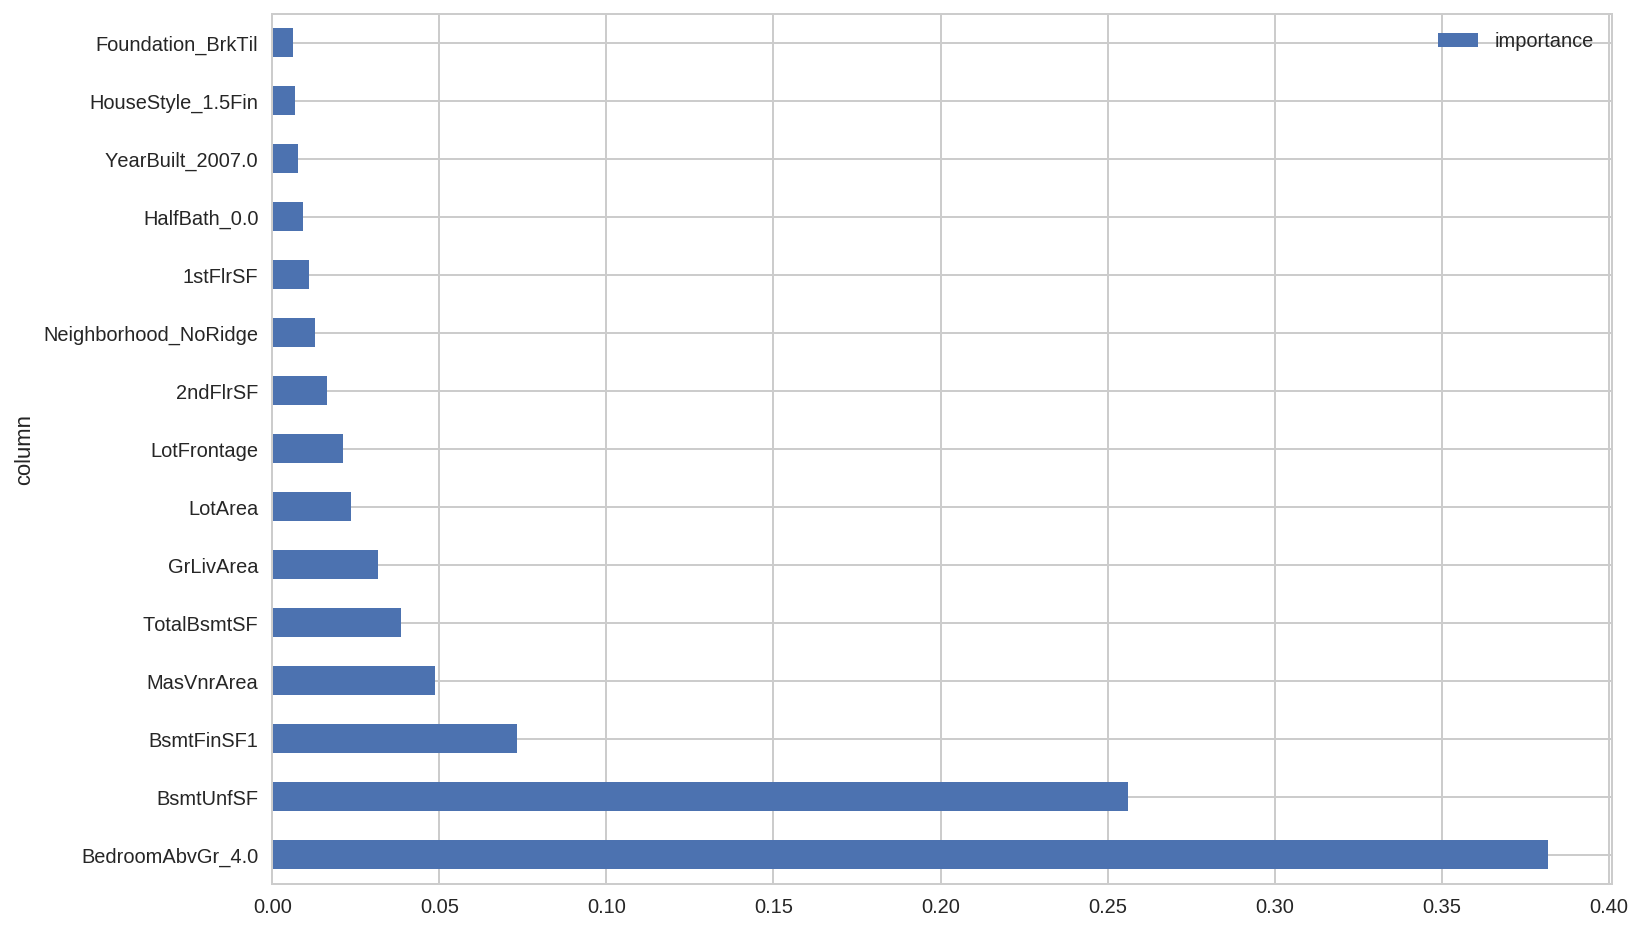

In [154]:
top_15_feat.plot(x='column', y='importance', kind='barh', sort_columns=True, figsize=(12, 8))
plt.show()

In [155]:
gs_rfr.best_estimator_.named_steps['regr'].n_features_

47

## Characterize your model. How well does it perform? What are the best estimates of price?

**Preprocessing:**
1. After first delineating the difference between fixed vs. renovatable features, I subsetted my original DataFrame to only hold fixed features. 
2. I then delineated my fixed features into two categories: (i) numeric and (ii) categorical
3. I subsuently used pd.get_dummies to get dummies on the categorical features, which expanded my DataFrame to hold 469 total features
4. A manual train/test/split was completed in order to use data for homes sold prior to 2010 to predict SalesPrice for homes sold in 2010.

**Model Characteristics:**
1. I built a pipeline, a parameters grid, and ultimately used GridSearchCV to optimize my over all model.

2. Pipeline: My pipeline began with a SelectKBest scored on f_regression. I opted to allow GridSearchCV to help determine what the best k features should be between 75, 100, and 125.  I then scaled my data using StandardScaler. Third, I used SelectFromModel with Lasso as the estimator. Lastly, I ran a RandomForestRegressor to fit my training data.
        rfr_pipe = Pipeline([
            ('skb', SelectKBest(score_func=f_regression)),
            ('scaler', StandardScaler()),
            ('sfm', SelectFromModel(Lasso())),
            ('regr', RandomForestRegressor(verbose=1, n_jobs=-1))
             ])
3. In the parameters dictionary built for GridSearchCV, I allowed GridSearchCV to help optimize the number of k's for the SelectKBest portion of my pipeline. I also tested 7 different alphas for my Lasso in SelectFromModel. Lastly, on my RandomForestRegressor, I wanted GridSearchCV to do the heavy lifting on determining which would be my best n_estimators and max_depth. Originally, I only ran the RandomForestRegressor with max_depth of 'None', but subsequently input 100 and 200 to see if 'pruning my trees' would help optimize my training and test score. 
        params = {
            'skb__k': [75, 100, 125],
            'sfm__estimator':[Lasso(alpha=a) for a in np.logspace(1, 3, 7)],
            'regr__n_estimators': [75, 100, 125],
            'regr__max_depth': [100, 200, None],
        }

**Model Results:**

After running GridSearchCV, which fit 945 models, the best parameters were the following:
- SelectKBest with k of 75
- SelectFromModel with Lasso with an alpha of 1000
- RandomForestRegressor with n_estimators of 75 and max_depth of None

With SelectKBest first running before scaling my data, 469 of my total features (after getting dummies) were reduced to 75, and then subsequently reduced once more to 47 features (after applying SelectFromModel with Lasso). While it seems redundant to run two feature-selection processes, the pipeline I selected seems to have done a decent job in narrowing in on more predictive features than not. 

    {'regr__max_depth': None,
     'regr__n_estimators': 75,
     'sfm__estimator': Lasso(alpha=1000.0, copy_X=True, fit_intercept=True, max_iter=1000,
        normalize=False, positive=False, precompute=False, random_state=None,
        selection='cyclic', tol=0.0001, warm_start=False),
     'skb__k': 75}



**Model Performance:**
- Train Score: 0.97330808500012456
- Test Score: 0.84994204048853716

Based on the train score and test score, the model performed reasonably well.
The RandomForestRegressor also has a feature importance attribute, which I used to rank the feature importances of the remaining 47 features from my original 469 in my dummied DataFrame.


**Features that were better predictors of SalePrice**:
While there were a total of 63 final features, I decided to look only at feature importances of > 0.005, which is summarized in the table below. Based on the output, and ignoring the dummies aspect of certain categorical features, the following appear to be the best predictors of price:
- Number of bedrooms (BedroomAbvGr_4.0), 
- Basements (BsmtUnfSF, BsmtFinSF1, TotalBsmtSF), 
- Mason Veneer Area (MasVnrArea), 
- Above grade living area (GrLivArea),
- Lot Frontage and Lot Area,
- whether a home has 1 story or 2 stories (HouseStyle and 1stFlrSF & 2ndFlrSF),  
- Neighborhood (Neighborhood_NoRidge),
- Number of bathrooms (HalfBath_0.0)
- the year a home was built (YearBuilt_2007.0), and
- the type of foundation a home has (Foundation_BrkTil).

While there are features that appear to make intuitive sense on being best predictors of SalesPrice, there are some features that appear to be redundant in nature such as the Basement features that might be colinear. Therefore, given more time, I would go back and run some further EDA to see covariance between certain features to see which columns could be eliminated from my fixed-features DataFrame or averaged together (and feature engineer a new column) to re-run my model against. Hopefully that would reveal if (i) different features emerge as being more important, or (ii) if more features are eliminated.

In [159]:
top_15_feat

,column,importance
0,BedroomAbvGr_4.0,0.381805
1,BsmtUnfSF,0.256239
2,BsmtFinSF1,0.073112
3,MasVnrArea,0.048540
4,TotalBsmtSF,0.038541
5,GrLivArea,0.031498
6,LotArea,0.023429
7,LotFrontage,0.021281
8,2ndFlrSF,0.016430
9,Neighborhood_NoRidge,0.012645


<function matplotlib.pyplot.plot>

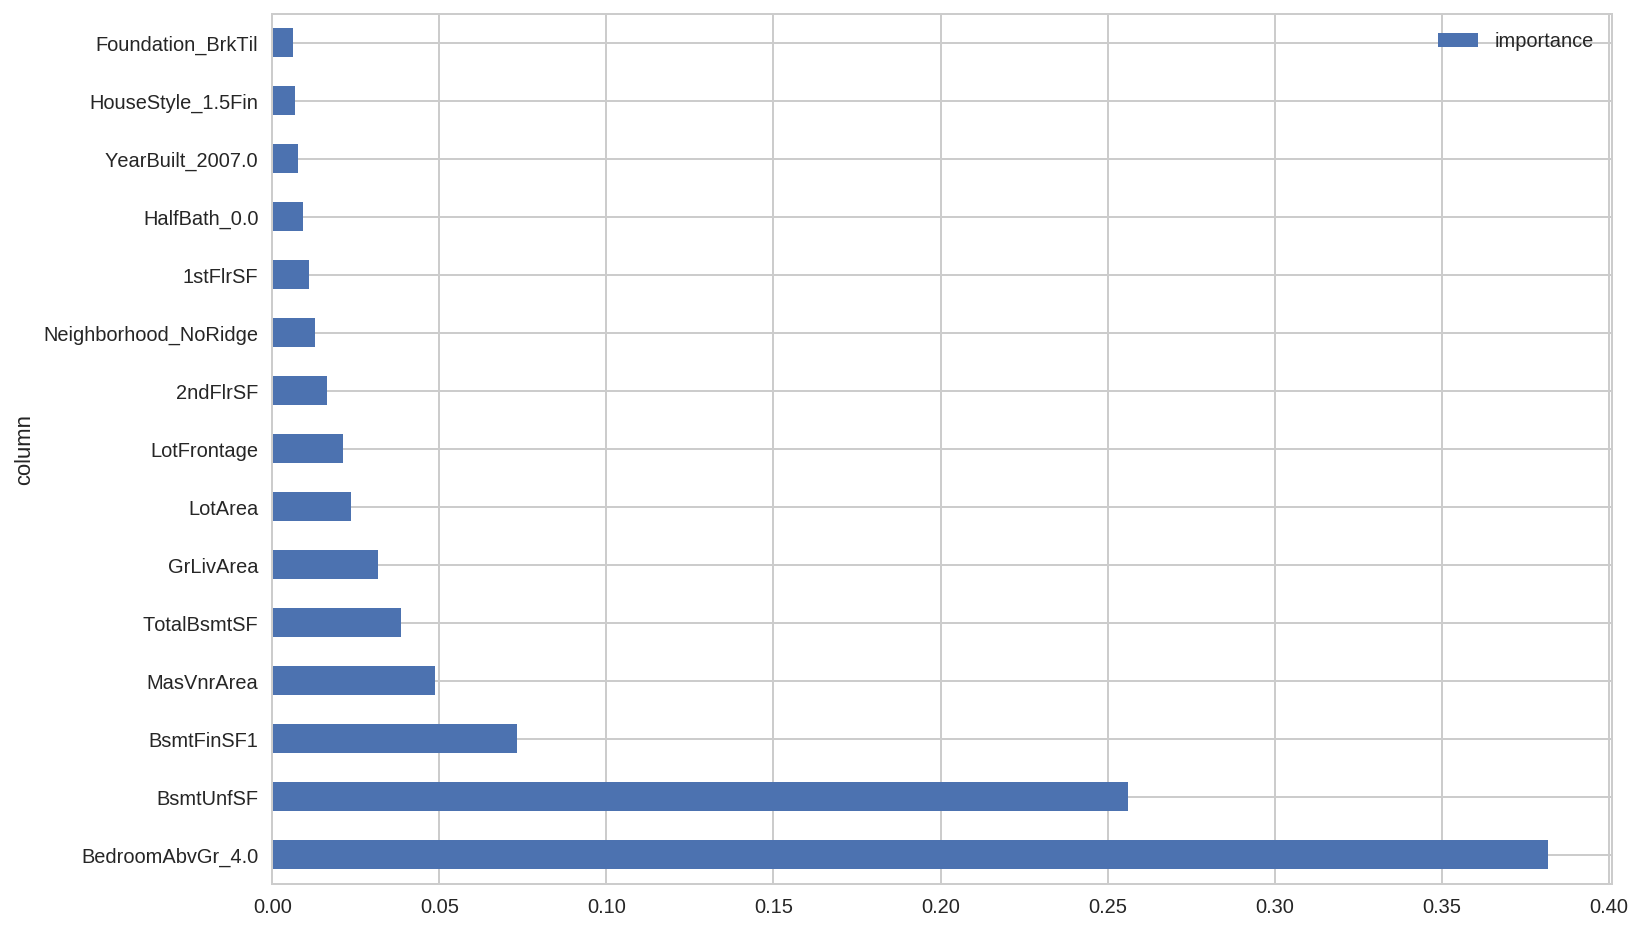

In [160]:
top_15_feat.plot(x='column', y='importance', kind='barh', figsize=(12,8))
plt.plot








<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones (explained by the *renovatable* features).

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

## Calculate the Predicted Values from Model 1 and the Residuals

In [162]:
# calculate predicted values from Model 1
y_test_preds = gs_rfr.predict(X_test)
y_test_preds.shape

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished


(164,)

In [161]:
# calculate predicted values from Model 1
y_train_preds = gs_rfr.predict(X_train)
y_train_preds.shape

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.0s finished


(1221,)

In [163]:
# calculate the residuals (actual minus predicted)
y_test_residual = y_test - y_test_preds
y_test_residual.shape

(164,)

In [185]:
y_train_residual = y_train - y_train_preds
y_train_residual.shape

(1221,)

In [164]:
# y_test_residual is my new y_test
# y_train_residual is my new y_train

## Clean the renovatable feature sub-DataFrame

In [165]:
list_unfixed_features

['Id',
 'OverallQual',
 'OverallCond',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'LowQualFinSF',
 'KitchenQual',
 'FireplaceQu',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'SalePrice']

In [166]:
df_renovatable = df_house[list_unfixed_features]
df_renovatable.drop(['Id', 'SalePrice'], axis=1, inplace = True) 
# ID numbers is not valuable information in predicting sales price
# SalePrice is what we're predicting as target, therefore drop it from the DataFrame

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [167]:
df_renovatable.head()

,OverallQual,OverallCond,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,...,HeatingQC,CentralAir,Electrical,LowQualFinSF,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC,Fence
0,7,5,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,...,Ex,Y,SBrkr,0,Gd,NA,TA,TA,NA,NA
1,6,8,1976,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,...,Ex,Y,SBrkr,0,TA,TA,TA,TA,NA,NA
2,7,5,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,...,Ex,Y,SBrkr,0,Gd,TA,TA,TA,NA,NA
3,7,5,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,...,Gd,Y,SBrkr,0,Gd,Gd,TA,TA,NA,NA
4,8,5,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,...,Ex,Y,SBrkr,0,Gd,TA,TA,TA,NA,NA


In [168]:
df_renovatable.columns

Index(['OverallQual', 'OverallCond', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF',
       'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence'],
      dtype='object')

In [169]:
# sort the difference between numeric and categorical columns for unfixed features 
# a/k/a renovatable features
list_unfixed_features_num = ['LowQualFinSF', ]
list_unfixed_features_cat = [col for col in df_renovatable.columns if col not in list_unfixed_features_num]

In [170]:
df_renovatable_dummies = pd.get_dummies(df_renovatable, columns=list_unfixed_features_cat)

In [171]:
df_renovatable.shape

(1385, 26)

In [172]:
df_renovatable_dummies.shape

(1385, 218)

## Do a manual train/test/split on the Renovatable Feature DataFrame

In [174]:
# the y_test and y_train were already established above with y_test_residual & y_train_residual

In [175]:
X_test_ren = df_renovatable_dummies[df_house['YrSold'] == 2010]
X_train_ren = df_renovatable_dummies[df_house['YrSold'] != 2010]

In [176]:
X_test_ren.shape

(164, 218)

In [177]:
X_train_ren.shape

(1221, 218)

In [178]:
np.where(df_renovatable_dummies.isnull())
# there are no null values in the DataFrame

(array([], dtype=int64), array([], dtype=int64))

## Run a Regression model using Feature Selection (Lasso)


In [230]:
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regr', Lasso())
     ])

In [231]:
lasso_params = {
    'regr__alpha':[a for a in np.logspace(1, 3, 7)]
}


In [232]:
lasso_gs = GridSearchCV(lasso_pipe, param_grid=lasso_params, n_jobs=-1, cv=5, verbose=1)

In [233]:
lasso_gs.fit(X_train_ren, y_train_residual)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.0s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regr', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'regr__alpha': [10.0, 21.544346900318832, 46.415888336127772, 100.0, 215.44346900318823, 464.15888336127773, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [237]:
lasso_gs.best_params_

{'regr__alpha': 464.15888336127773}

In [236]:
lasso_gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regr', Lasso(alpha=464.15888336127773, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])

In [238]:
lasso_gs.best_score_

0.077848898446893869

In [326]:
lasso_gs.score(X_train_ren, y_train_residual)

0.23263616373595622

In [243]:
pd.DataFrame(lasso_gs.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_regr__alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
5,0.015010,0.005427,0.077849,0.259571,464.159,{'regr__alpha': 464.158883361},1,0.049739,0.252123,0.000437,...,0.099065,0.246773,0.169607,0.248539,0.070511,0.221459,0.001524,0.001351,0.056030,0.036355
6,0.015279,0.004486,0.062790,0.167759,1000,{'regr__alpha': 1000.0},2,0.027655,0.167847,-0.009370,...,0.085613,0.158207,0.153804,0.157435,0.056391,0.132371,0.000295,0.001229,0.055280,0.029982
4,0.019590,0.006852,0.054173,0.310033,215.443,{'regr__alpha': 215.443469003},3,0.028373,0.299866,0.001517,...,0.100515,0.292601,0.089379,0.297436,0.051187,0.268784,0.007850,0.001350,0.036963,0.042192
3,0.038221,0.004687,0.017401,0.335941,100,{'regr__alpha': 100.0},4,-0.018411,0.324121,-0.016183,...,0.072731,0.315830,0.025670,0.322154,0.023346,0.293074,0.007911,0.001074,0.033395,0.045650
2,0.040811,0.004072,-0.015954,0.345793,46.4159,{'regr__alpha': 46.4158883361},5,-0.058251,0.331893,-0.042470,...,0.045195,0.324813,-0.017752,0.331161,-0.006319,0.303035,0.011317,0.001138,0.035580,0.047306


## Evaluate the effect in dollars of the renovate-able features. 
The coefficients from the regression model measure the effect in SalePrice residuals (from model 1 above) from the renovatable features.

In [253]:
lasso_coefs = lasso_gs.best_estimator_.named_steps['regr'].coef_
len(lasso_coefs)

218

In [252]:
df_renovatable_dummies.columns

Index(['LowQualFinSF', 'OverallQual_1', 'OverallQual_2', 'OverallQual_3',
       'OverallQual_4', 'OverallQual_5', 'OverallQual_6', 'OverallQual_7',
       'OverallQual_8', 'OverallQual_9',
       ...
       'GarageCond_TA', 'PoolQC_Ex', 'PoolQC_Fa', 'PoolQC_Gd', 'PoolQC_NA',
       'Fence_GdPrv', 'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw', 'Fence_NA'],
      dtype='object', length=218)

In [262]:
lasso_feat_coefs = list(zip(df_renovatable_dummies.columns, lasso_coefs))

## How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money.

The second model and its coefficients should not be used to determine whether the house-flipping company should acdquire a property. The better method would have been to predict the SalePrice using renovatable features instead of predicting residuals from model 1. 

Note the following: 
$$ \hat{y} = \hat{y}_{(fixed)} + \hat{y}_{(renovatable)}$$
$$ \hat{y} - \hat{y}_{(fixed)} = \hat{y}_{(renovatable)}$$

We are being asked to predict the residuals from the first model, which is calculated as follows:
$$ {y} - \hat{y}_{(fixed)} = \text{residual}_{(model 1)}$$

$$ \hat{y} - \hat{y}_{(fixed)} \ne {y} - \hat{y}_{(fixed)}$$ unless $$ \hat{y} = {y}$$

We did get reasonably close to having $$\hat{y} = {y}$$ based on the scores found in Model 1. Therefore, it's unlikely that the remaining features that are considered renovatable would be able to do a much better job explaining the residuals from Model 1 and would only be incrementally and immaterially additive to predicting SalePrice of a given property as shown by the scores yielded from the second model (as shown below):
- Train Score: 0.23263616373595622
- Test Score: 0.077848898446893869

In [277]:
df_lasso_feat = pd.DataFrame(data=lasso_feat_coefs, columns=['feature', 'coefficient'])
df_lasso_sel_feat = df_lasso_feat[df_lasso_feat['coefficient'] != 0].sort_values(by='coefficient', ascending=False)

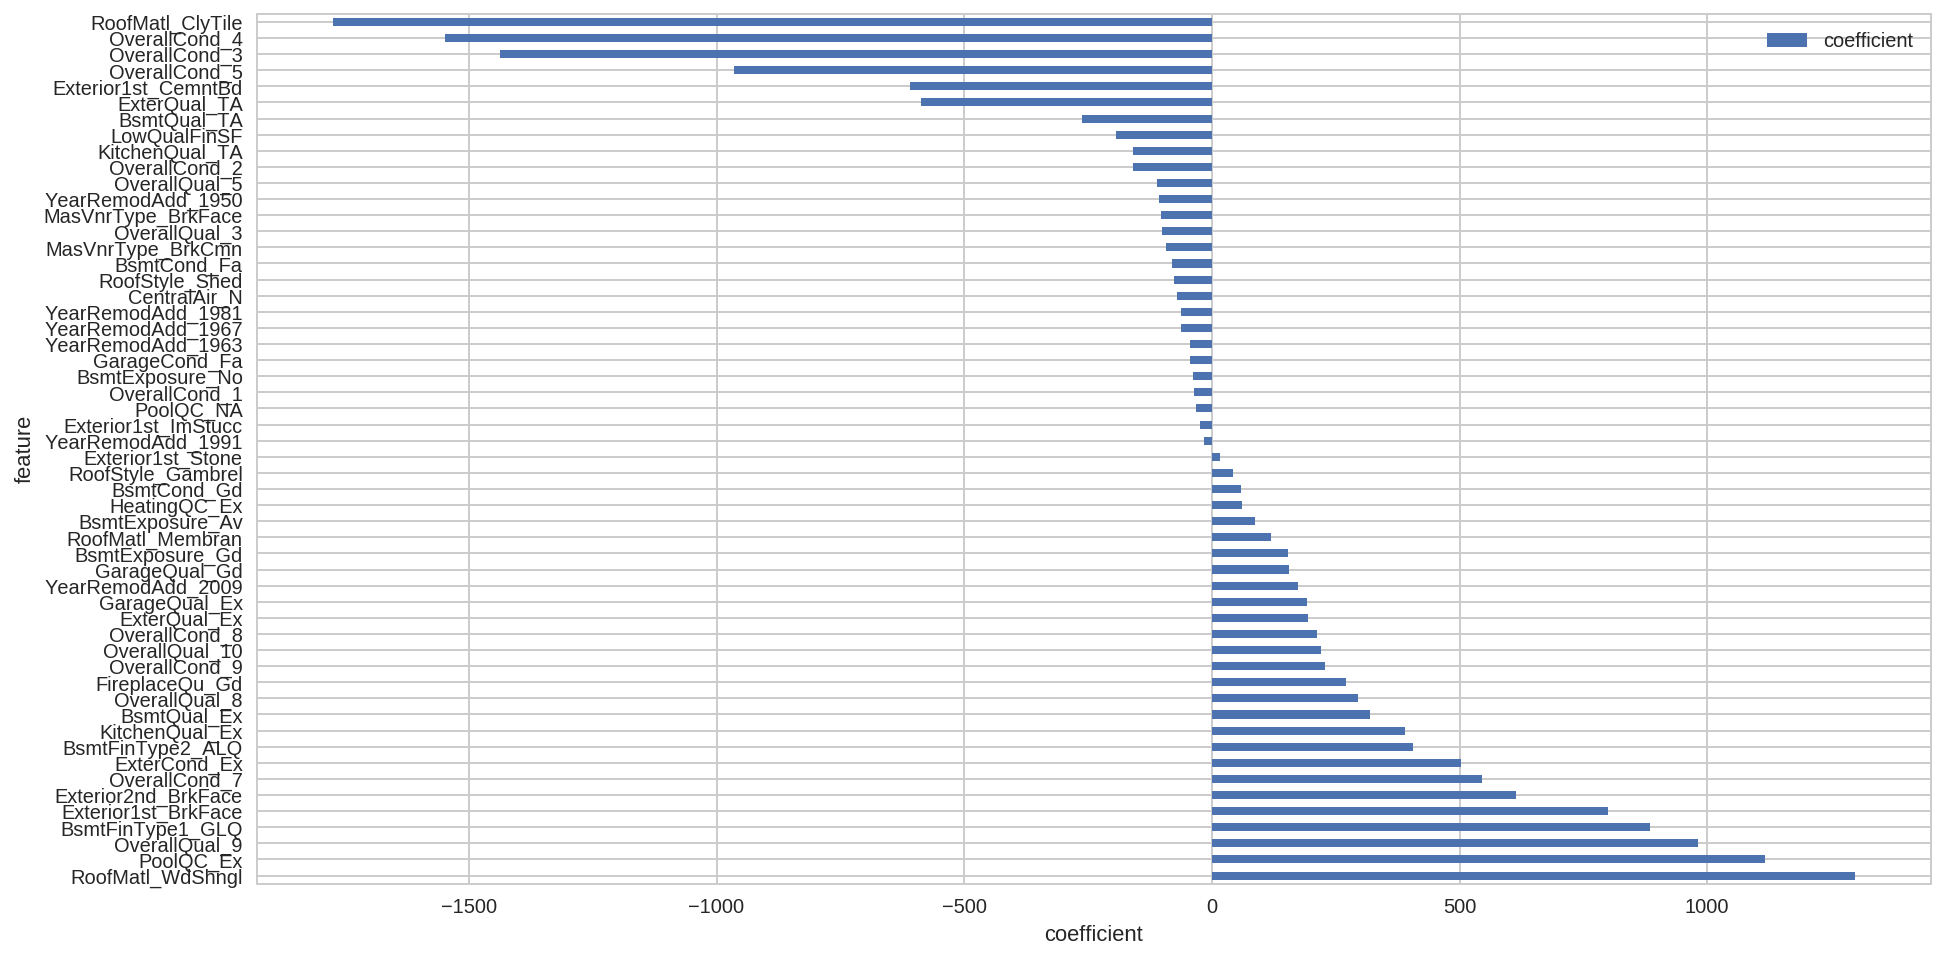

In [281]:
df_lasso_sel_feat.plot(kind='barh', figsize=(15,8), x='feature', y='coefficient')
plt.xlabel('coefficient')
plt.show()

## Investigate how much of the variance in price remaining is explained by these features.
54 of the 218 features were selected by using Lasso in my second model. Based on the test score, only about 7% of the variance from model 1 is explained by the renovatable features. Nevertheless, this should be disregarded based on how poor the train score was. See explanation below.


In [328]:
len(df_lasso_sel_feat)

54

## Do you trust your model? Should it be used to evaluate which properties to buy and fix up?
I do not trust the output of the second model since both the train and test score were poor. To determine which properties to purchase, I believe a better alternative would be to look at the features that were selected from the first model, or to look at a new model that considers all features and does not subset the original data into renovatable features vs. fixed features. 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price). 


In [315]:
# I'm pretty sure that the bank offering him first dibs on pre-auction purchase is illegal and unethical.


He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [123]:
# A: